By [Kevin Michalewicz](https://kevinmichalewicz.com) on August 2022

This notebook shows how to deconvolve a JWST galaxy image for the F200W band. Before that, the narrow PSF is obtained. It is important to notice that the noise maps are given in this case.

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from copy import deepcopy
from matplotlib import colors

from starred.deconvolution.deconvolution import Deconv, setup_model
from starred.deconvolution.loss import Loss as decLoss
from starred.deconvolution.parameters import ParametersDeconv
from starred.utils.noise_utils import propagate_noise
from starred.utils.optimization import Optimizer

from starred.plots import plot_function as pltf

from starred.psf.psf import PSF
from starred.psf.loss import Loss
from starred.psf.parameters import ParametersPSF

from starred.utils.generic_utils import save_fits
from starred.utils import ds9reg
from starred.utils.noise_utils import propagate_noise

from jax.config import config; config.update("jax_enable_x64", True) #we require double digit precision

In [2]:
# Parameters
subsampling_factor = 2
n_iter_initial = 50
n_iter = 2000 #epoch for adabelief

lambda_scales = 1.5
lambda_hf = 2.5
lambda_positivity = 0. #prevent the background to have a median value much below 0. In case this is happening, you can remove degeneracy with the moffat profile with this parameter. 
include_moffat = True
regularize_full_psf = False #If True, regularise [m(x)+b(x)]. Regularise only the b(x) if False. 

method_analytical = 'trust-constr'
method = 'adabelief'
data_path = 'data/4_observations'
noise_map_path = 'data/4_obs_noise_maps'
convolution_method = 'fft'

In [3]:
# Data 
file_paths_data = sorted(glob.glob(os.path.join(data_path, '*.npy')))
new_vignets_data = np.array([np.load(f) for f in file_paths_data]) 
N = len(file_paths_data) # number of stars
image_size = np.shape(new_vignets_data)[1] # data dimensions
image_size_up = image_size * subsampling_factor 

In [4]:
# Masking
masks = np.ones((N, image_size, image_size))
for i in range(N):
    possiblemaskfilepath = os.path.join(noise_map_path, 'mask_%s.reg'%str(i))
    if os.path.exists(possiblemaskfilepath):
        reg = ds9reg.Regions(image_size, image_size) 
        reg.readds9(possiblemaskfilepath, verbose=False)
        reg.buildinvertedmask(verbose=False)
        masks[i,:,:] = reg.nomask

In [5]:
# Noise map obtention
sigma_paths = sorted(glob.glob(os.path.join(noise_map_path, '*.npy')))
sigma_2 = np.array([np.load(f) for f in sigma_paths]) ** 2

#Renormalise your data and the noise maps by the max of the first image. Works better when using adabelief
norm = new_vignets_data[0].max() / 100.
new_vignets_data /= norm
sigma_2 /= norm**2

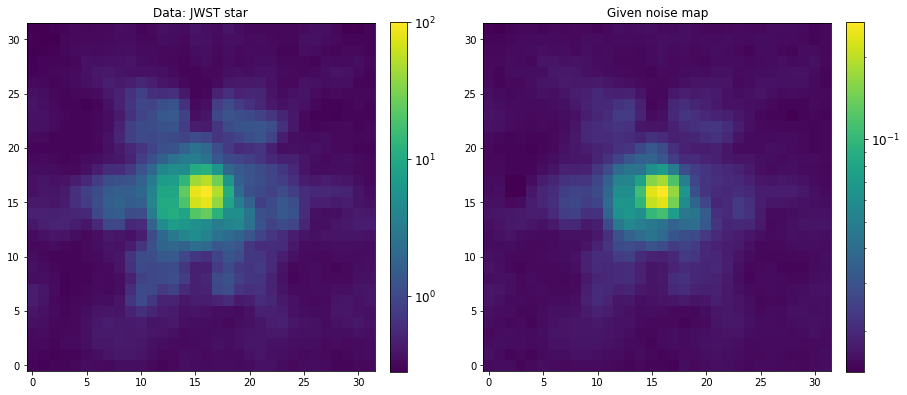

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
fraction = 0.046
pad = 0.04

plt.rc('font', size=12)           
axs[0].set_title('Data: JWST star', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_title('Given noise map', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=10)

fig.colorbar(axs[0].imshow(new_vignets_data[0,:,:], norm=colors.SymLogNorm(linthresh=1), origin='lower'), ax=axs[0], fraction=fraction, pad=pad)
fig.colorbar(axs[1].imshow(np.sqrt(sigma_2[0,:,:]), norm=colors.LogNorm(), origin='lower'), ax=axs[1], fraction=fraction, pad=pad)
plt.show()

In [7]:
# Build the PSF model class
model = PSF(image_size=image_size, number_of_sources=N, 
            upsampling_factor=subsampling_factor, 
            convolution_method=convolution_method,
            include_moffat = include_moffat)

# Parameter initialization. 
kwargs_init, kwargs_fixed, kwargs_up, kwargs_down = model.smart_guess(new_vignets_data, fixed_background=True)

print('Initial Guess :', kwargs_init) 

parameters = ParametersPSF(model, kwargs_init, kwargs_fixed, kwargs_up=kwargs_up, kwargs_down=kwargs_down)

Initial Guess : {'kwargs_moffat': {'fwhm': 3.0, 'beta': 2.0, 'C': 95.35240061594526}, 'kwargs_gaussian': {'a': DeviceArray([1., 1., 1.], dtype=float64), 'x0': array([-0.08397102, -0.24713516,  0.19010353]), 'y0': array([0.02102089, 0.30672264, 0.14050484])}, 'kwargs_background': {'background': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64)}}


In [8]:
# Moffat fitting and amplitude tunning 
loss = Loss(new_vignets_data, model, parameters, sigma_2, N, regularization_terms='l1_starlet', 
            regularization_strength_scales=0, regularization_strength_hf=0) 
optim = Optimizer(loss, parameters, method=method_analytical)

optimiser_scipy_option = {'maxiter':n_iter_initial, 'restart_from_init':True, 'use_grad':True, 'use_hessian':False, 'use_hvp':True}

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_scipy_option)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +1.1346e+06 | 1.00e+00 | 6.27e+05 | 0.00e+00 |
|   2   |   2   |   2   | +8.2156e+05 | 7.00e+00 | 2.23e+05 | 0.00e+00 |
|   3   |   3   |   5   | +8.2156e+05 | 7.00e-01 | 2.23e+05 | 0.00e+00 |
|   4   |   4   |   6   | +6.9820e+05 | 4.90e+00 | 2.91e+05 | 0.00e+00 |
|   5   |   5   |  14   | +6.9820e+05 | 4.90e-01 | 2.91e+05 | 0.00e+00 |
|   6   |   6   |  16   | +6.7645e+05 | 9.80e-01 | 5.02e+05 | 0.00e+00 |
|   7   |   7   |  23   | +5.8481e+05 | 6.86e+00 | 1.08e+05 | 0.00e+00 |
|   8   |   8   |  30   | +5.6797e+05 | 4.80e+01 | 2.01e+04 | 0.00e+00 |
|   9   |   9   |  42   | +5.6445e+05 | 4.80e+01 | 2.05e+05 | 1.57e-01 |
|  10   |  11   |  54   | +5.6445e+05 | 4.80e+00 | 2.05e+05 | 1.57e-01 |
|  11   |  12   |  63   | +5.6445e+05 | 4.80e-01 | 2.05e+05 | 1.57e-01 |
|  12   |  13   |  67   | +5.6445e+05 | 9.86e-02 | 

Moffat fit : {'kwargs_moffat': {'fwhm': array([0.5993485]), 'beta': array([1.00428548]), 'C': array([909.82879011])}, 'kwargs_gaussian': {'a': array([8.84243658e-06, 1.51699674e-05, 1.69216930e-05]), 'x0': array([ 0.0833416 , -0.18944047,  0.29413589]), 'y0': array([0.16300556, 0.35965196, 0.14626236])}, 'kwargs_background': {'background': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64)}}


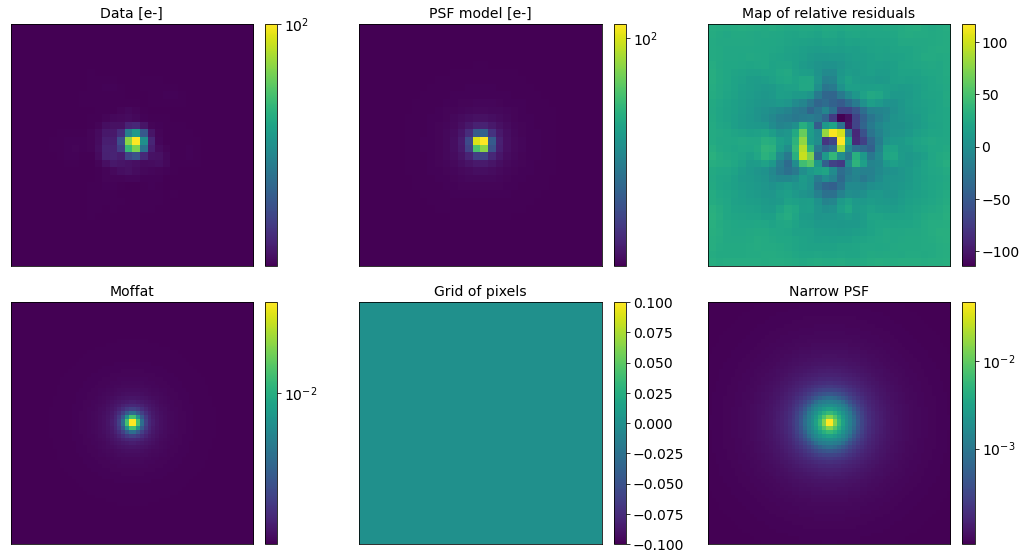

In [9]:
# Printing partial results
kwargs_partial = parameters.args2kwargs(best_fit)
print('Moffat fit :',kwargs_partial) 

fig2 = pltf.single_PSF_plot(model, new_vignets_data, sigma_2, kwargs_partial, n_psf=0, units='e-')

4.105495393188788
0.92847183550793
0.39321578173832716
0.18665726289126827
0.08921831008958689
0.04350780496332137
0.021930354465954073


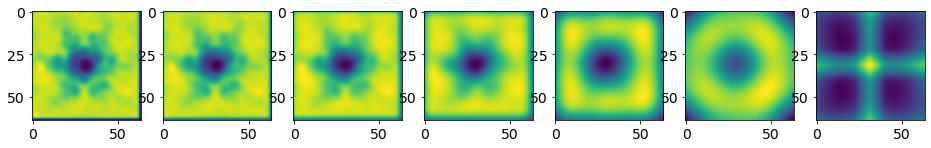

In [10]:
# compute noise level in starlet space, also propagate poisson noise
W = propagate_noise(model, np.sqrt(sigma_2), kwargs_partial, wavelet_type_list=['starlet'], method='SLIT', num_samples=5000,
             seed=1, likelihood_type='chi2', verbose=False, upsampling_factor=subsampling_factor)[0]

#This is a representation of your noise level (background + Poisson) in the different starlet scales
gix, axs = plt.subplots(1, len(W), figsize=(16, 4))
for i, l in enumerate(W):
    axs[i].imshow(l)
    print(np.mean(l))
plt.show()
# You can save these noise maps to avoid recomputation
#np.save('./input/W_SLIT_chi2.npy', W)

In [11]:
# Release backgound, fix the moffat
kwargs_fixed = {
    'kwargs_moffat': {'fwhm': kwargs_partial['kwargs_moffat']['fwhm'], 'beta': kwargs_partial['kwargs_moffat']['beta'], 'C':kwargs_partial['kwargs_moffat']['C']},
    'kwargs_gaussian': {},
    'kwargs_background': {},
}

parameters = ParametersPSF(model, kwargs_partial, kwargs_fixed, kwargs_up, kwargs_down)

loss = Loss(new_vignets_data, model, parameters, sigma_2, N, regularization_terms='l1_starlet',
            regularization_strength_scales=lambda_scales, regularization_strength_hf=lambda_hf,
            regularization_strength_positivity=lambda_positivity, W=W, regularize_full_psf=regularize_full_psf)


optim = Optimizer(loss, parameters, method=method)
optimiser_optax_option = {
                            'max_iterations':n_iter, 'min_iterations':None,
                            'init_learning_rate':1e-2, 'schedule_learning_rate':True,
                            'restart_from_init':False, 'stop_at_loss_increase':False,
                            'progress_bar':True, 'return_param_history':True
                        }           

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)

optax.adabelief: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 485.83it/s]


{'kwargs_moffat': {'fwhm': array([0.5993485]), 'beta': array([1.00428548]), 'C': array([909.82879011])}, 'kwargs_gaussian': {'a': DeviceArray([-0.03463815, -0.05896172, -0.06580507], dtype=float64), 'x0': DeviceArray([ 0.16818271, -0.09148065,  0.47754236], dtype=float64), 'y0': DeviceArray([0.1835844 , 0.45449911, 0.14726145], dtype=float64)}, 'kwargs_background': {'background': DeviceArray([ 1.92548657,  0.39453531,  0.34592795, ...,  0.2014441 ,
             -0.86746424,  3.30397852], dtype=float64)}}
Overall Reduced Chi2 :  123.45874017561894
Loss :  68246.7485946027
Log Likelihood :  -63210.8749699169
Log Regul :  -5035.873624685799
Log regul positivity : -0.0


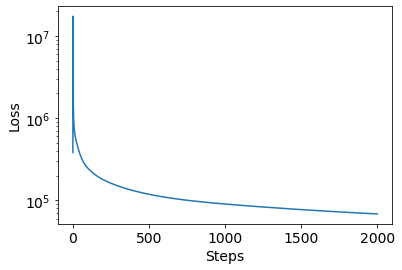

In [12]:
kwargs_final = parameters.args2kwargs(best_fit)
print(kwargs_final)

loss_history = extra_fields['loss_history']
param_history = extra_fields['param_history']

plt.plot(range(n_iter), loss_history)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')

print('Overall Reduced Chi2 : ', -2 * loss._log_likelihood_chi2(kwargs_final) / (image_size**2) )
print('Loss : ', loss.loss(best_fit))
print('Log Likelihood : ', loss._log_likelihood(kwargs_final))
print('Log Regul : ', loss._log_regul(kwargs_final))
print('Log regul positivity :', loss._log_regul_positivity(kwargs_final))

In [13]:
# Example on how to retrieve different elements of the PSF 
n_psf = 0
estimated_full_psf = model.model(n_psf, **kwargs_final)
analytic = model.get_moffat(kwargs_final['kwargs_moffat'], norm=True)
s = model.get_narrow_psf(**kwargs_final, norm=True)
background = model.get_background(kwargs_final['kwargs_background'])

dif = new_vignets_data[n_psf,:,:] - estimated_full_psf
rr = np.abs(dif) / np.sqrt(sigma_2[n_psf,:,:])

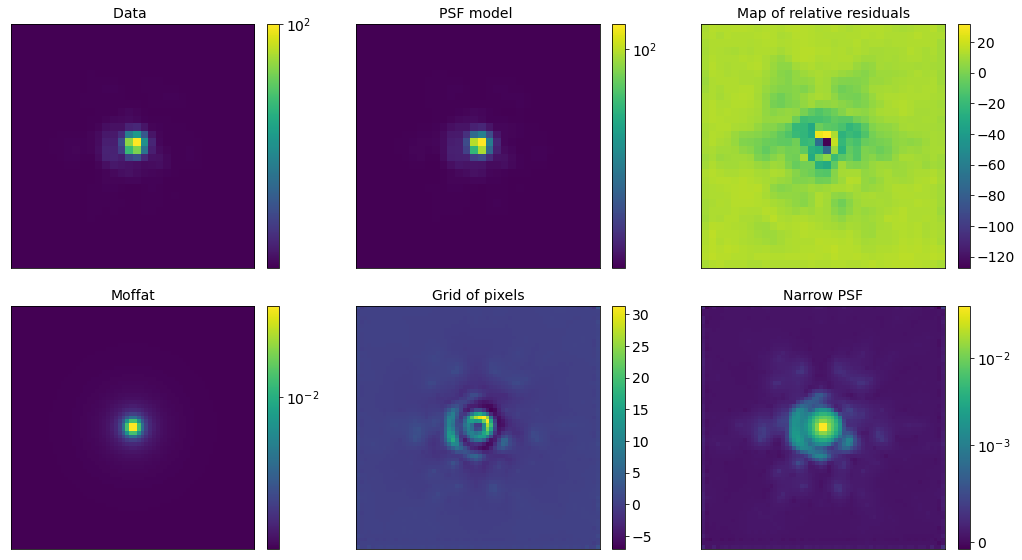

In [14]:
fig2 = pltf.single_PSF_plot(model, new_vignets_data, sigma_2, kwargs_final, n_psf=0)

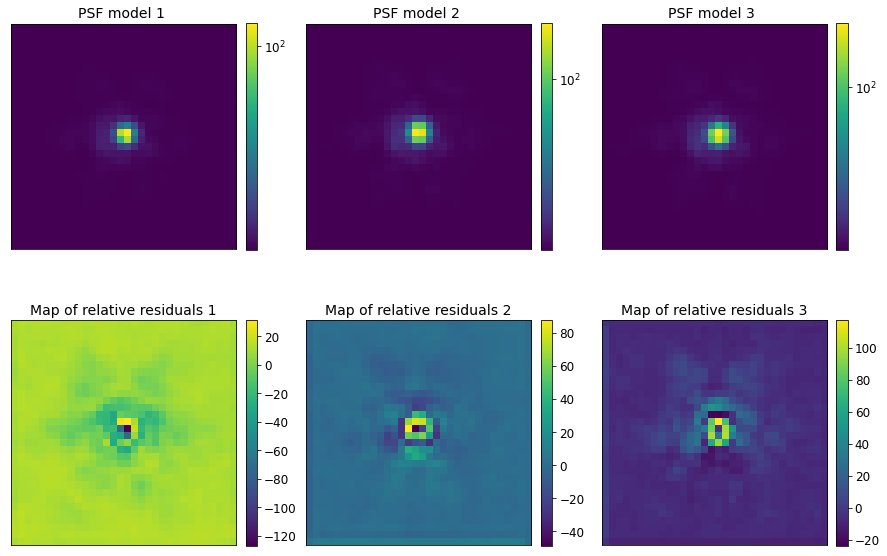

In [15]:
fig3 = pltf.multiple_PSF_plot(model, new_vignets_data, sigma_2, kwargs_final)

In [16]:
# Parameters
epochs = 1
subsampling_factor = 2
n_iter = 20
M = 0
method = 'trust-constr'
lambda_scales = 2
lambda_hf = 2
data_path = 'data/4_galaxy_observation'
noise_map_path = 'data/4_galaxy_noise_map'

In [17]:
# Retrieving data
file_paths = sorted(glob.glob(os.path.join(data_path, '*.npy')))
data = np.array([np.load(f) for f in file_paths])/1.

im_size = np.shape(data)[1]
im_size_up = im_size * subsampling_factor

print(data.shape)

(1, 80, 80)


In [18]:
# PSF reshaping
s = s.reshape(epochs, s.shape[-1], s.shape[-1])
print(s.shape)

(1, 64, 64)


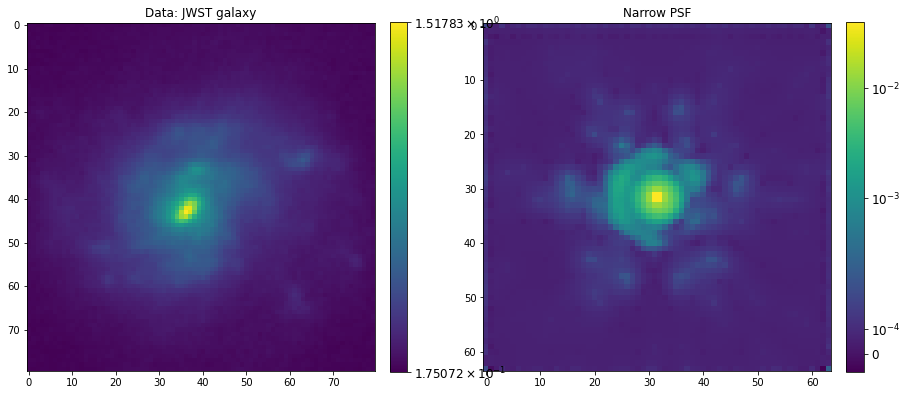

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
fraction = 0.046
pad = 0.04

plt.rc('font', size=12)           
axs[0].set_title('Data: JWST galaxy', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_title('Narrow PSF', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=10)

fig.colorbar(axs[0].imshow(data[0,:,:], norm=colors.SymLogNorm(linthresh=10)), ax=axs[0], fraction=fraction, pad=pad)
fig.colorbar(axs[1].imshow(s[0,:,:], norm=colors.SymLogNorm(linthresh=5e-4)), ax=axs[1], fraction=fraction, pad=pad)
plt.show()

In [20]:
# Noise map obtention
sigma_paths = sorted(glob.glob(os.path.join(noise_map_path, '*.npy')))
sigma_2 = np.array([np.load(f) for f in sigma_paths]) ** 2

In [21]:
# Parameter initialization
initial_c_x = np.array([]) 
initial_c_y = np.array([]) 
initial_a = []

model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(data, 
                                                                       sigma_2, 
                                                                       s, 
                                                                       initial_c_x,
                                                                       initial_c_y,
                                                                       initial_a, 
                                                                       subsampling_factor)

parameters = ParametersDeconv(model, kwargs_init, 
                              kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)


Padding the PSFs to match the upsampled image size...


In [22]:
model.model(kwargs_init)

DeviceArray([[[0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              ...,
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.]]], dtype=float64)

In [23]:
# compute noise level in starlet space
W = propagate_noise(model, np.sqrt(sigma_2), kwargs_partial, wavelet_type_list=['starlet'], 
                    method='SLIT', num_samples=500, seed=1, likelihood_type='chi2', 
                    verbose=False, upsampling_factor=subsampling_factor)[0]

loss = decLoss(data, model, parameters, sigma_2, 
               regularization_terms='l1_starlet', 
               regularization_strength_scales=lambda_scales, 
               regularization_strength_hf=lambda_hf, W=W) 

optim = Optimizer(loss, parameters, method=method)

optim.minimize(maxiter=n_iter, restart_from_init=False, 
               use_grad=True, use_hessian=False, use_hvp=True) 


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +7.6592e+06 | 1.00e+00 | 2.21e+08 | 0.00e+00 |
|   2   |   2   |   4   | +4.2660e+05 | 7.00e+00 | 6.51e+04 | 0.00e+00 |
|   3   |   3   |  63   | +2.4257e+03 | 4.90e+01 | 1.32e+02 | 0.00e+00 |
|   4   |   4   |  121  | +2.4257e+03 | 1.34e+01 | 1.32e+02 | 0.00e+00 |
|   5   |   5   |  165  | +2.4257e+03 | 4.62e+00 | 1.32e+02 | 0.00e+00 |
|   6   |   6   |  196  | +2.4257e+03 | 2.31e+00 | 1.32e+02 | 0.00e+00 |
|   7   |   7   |  220  | +2.0011e+03 | 4.62e+00 | 1.54e+04 | 0.00e+00 |
|   8   |   8   |  255  | +2.0011e+03 | 2.31e+00 | 1.54e+04 | 0.00e+00 |
|   9   |   9   |  285  | +2.0011e+03 | 1.16e+00 | 1.54e+04 | 0.00e+00 |
|  10   |  10   |  310  | +1.2819e+03 | 2.31e+00 | 7.17e+02 | 0.00e+00 |
|  11   |  11   |  337  | +1.2819e+03 | 1.16e+00 | 7.17e+02 | 0.00e+00 |
|  12   |  12   |  363  | +1.2819e+03 | 5.78e-01 | 

(array([ 0.07528394, -0.03103238, -0.02324633, ..., -0.04377315,
        -0.04241482, -0.00335952]),
 DeviceArray(906.79305582, dtype=float64),
 {'result_class':          cg_niter: 506
       cg_stop_cond: 2
             constr: [array([0., 0., 0., ..., 0., 0., 0.])]
        constr_nfev: [0]
        constr_nhev: [0]
        constr_njev: [0]
     constr_penalty: 1.0
   constr_violation: 0.0
     execution_time: 3.1157703399658203
                fun: DeviceArray(906.79305582, dtype=float64)
               grad: array([ 4.55442966e+03, -5.94177514e-01, -1.83370315e+00, ...,
         -6.98490043e-01, -2.44741168e-01,  2.08934690e-02])
                jac: [<25601x25601 sparse matrix of type '<class 'numpy.float64'>'
  	with 25601 stored elements in Compressed Sparse Row format>]
    lagrangian_grad: array([ 4.55442966e+03, -5.94177514e-01, -1.83370315e+00, ...,
         -6.98490043e-01, -2.44741168e-01,  2.08934690e-02])
            message: 'The maximum number of function evaluations is 

In [24]:
# Printing final results
kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))
print(kwargs_final)

{'kwargs_analytic': {'a': array([], dtype=float64), 'c_x': array([], dtype=float64), 'c_y': array([], dtype=float64), 'dx': array([], dtype=float64), 'dy': array([], dtype=float64)}, 'kwargs_background': {'mean': array([0.07528394]), 'h': array([-0.03103238, -0.02324633, -0.01941904, ..., -0.04377315,
       -0.04241482, -0.00335952])}}


In [25]:
# Retrieving different elements of the deconvolved image
epoch = 0
output = model.model(kwargs_final)[epoch]
deconv, h = model.getDeconvolved(kwargs_final, epoch)

data_show = data[epoch,:,:] 

dif = data_show - output
rr = np.abs(dif) / np.sqrt(sigma_2[epoch,:,:])

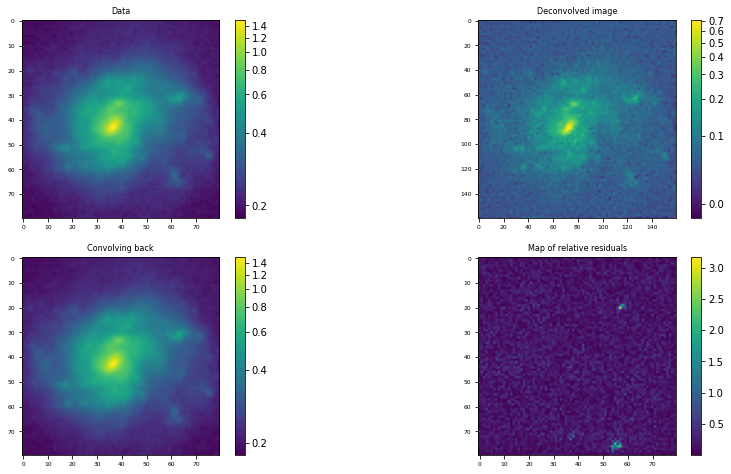

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(15,8))
fraction = 0.046
pad = 0.04
font_size = 10
ticks_size = 6

from astropy.visualization import (imshow_norm, MinMaxInterval,
                                   SqrtStretch, AsinhStretch)
stretch = AsinhStretch

plt.rc('font', size=font_size)           
axs[0,0].set_title('Data', fontsize=8)
axs[0,0].tick_params(axis='both', which='major', labelsize=ticks_size)

axs[0,1].set_title('Deconvolved image', fontsize=8)
axs[0,1].tick_params(axis='both', which='major', labelsize=ticks_size)

axs[1,0].set_title('Convolving back', fontsize=8)
axs[1,0].tick_params(axis='both', which='major', labelsize=ticks_size)

axs[1,1].set_title('Map of relative residuals', fontsize=8)
axs[1,1].tick_params(axis='both', which='major', labelsize=ticks_size)


im, norm = imshow_norm(data_show, axs[0,0], interval=MinMaxInterval(), stretch=stretch())
fig.colorbar(im, ax=axs[0,0], fraction=fraction, pad=pad)
im2, _ = imshow_norm(h, axs[0,1], interval=MinMaxInterval(), stretch=stretch())
fig.colorbar(im2, ax=axs[0,1], fraction=fraction, pad=pad)
fig.colorbar(axs[1,0].imshow(output, norm=norm), ax=axs[1,0], fraction=fraction, pad=pad)
fig.colorbar(axs[1,1].imshow(rr), ax=axs[1,1], fraction=fraction, pad=pad) 
plt.show()

In [27]:
input_flux = data.sum()
output_flux = output.sum()

print('Data flux: ' + str(input_flux))
print('Deconvolved image flux: ' + str(output_flux))
print('Flux change: ' + str(100 * abs(input_flux-output_flux) / input_flux) + '%')

Data flux: 1947.2152
Deconvolved image flux: 1947.3637341368726
Flux change: 0.007627517244901135%


In [28]:
#save results 
#from starred.utils.generic_utils import save_fits

#output_path = './output_JWST'
#save_fits(s, os.path.join(output_path, 's'))
#save_fits(data, os.path.join(output_path, 'data'))
#save_fits(output, os.path.join(output_path, 'output'))
#save_fits(cback, os.path.join(output_path, 'cback'))